## Analysis sparks

In [1]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Imagenes_confocal/Rata/C071112/'
photo_name = 'c3ack009'
x_calibracion = 4.5

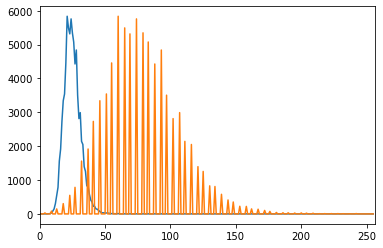

In [2]:
from sparks_image import *

image = cv2.imread(path + photo_name + ".tif")    # Read image

list_img_col = image_process (image)

from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

img_bc = interactive(f, brightness=100, contrast=100)   #display brightness and contrast
display (img_bc)

im = rotation (imCrop, 90)    # rotate image
display_image ('Image' , im)    # Display cropped image

## **Aplicación de análisis sobre picos** 

In [10]:
from sparks_analysis import *

In [11]:
def maximo_peak (vector):
    import numpy as np
    from peakutils.peak import indexes
    import peakutils
    indexes = indexes(np.array(vector), thres=1.0/max(vector), min_dist=10)
    kk = list(indexes)
    for j in kk:
        if vector[j]> (sum(vector) / len(vector)):
            tiempos = j
            intensidades = vector[j]
    return tiempos,intensidades

cantidad_sparks = len(list_img_col)

datos_tiempos = {}
datos_intensidades = {}

for i in range (0,cantidad_sparks):
    picos = maximo_peak (list_img_col[i])
    datos_tiempos [i] = picos [0]
    datos_intensidades [i] = picos [1]
    

Columns = ['Spark_'+ str(x) for x in range(0, cantidad_sparks)]
out_sparks = pd.DataFrame([datos_tiempos.values(),datos_intensidades.values()], columns = Columns).T
out_sparks = pd.DataFrame(out_sparks.values, columns = ['tiempo_maximo', 'intensidad_maxima'])

In [12]:
#  Detección de mínimos locales
# Calculate the n-th discrete difference along the given axis. The first difference is given by out[i] = a[i+1] - a[i] along the given axis, higher differences are calculated by using diff recursively.
# The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0. nan is returned for nan inputs.

def minimo_bl (vector):
    data = np.asarray(vector,dtype=np.int)
    b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1
    return b

# Esta celda calcula los mínimos de la selección de toda la célula tomando los mínimos calculados, quedandose con el más chico entre dos máximos.
# Devuelve el valor de tiempos y las intensidades en dataframes por separado.

sparks_tiempo0 = []
sparks_intensidad0 = []        
sparks_tiempo_n = []
sparks_intensidad_n = []

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_col[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks['tiempo_maximo'][i])
        if minimo < picomenor:
            y_min = list_img_col[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo0.append(minimo_lista_mins[0])
        sparks_intensidad0.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_col[i][0:int(out_sparks['tiempo_maximo'][i])])
        minimimo = list_img_col[i].index(minimo_lista_mins)
        sparks_tiempo0.append(minimimo)
        sparks_intensidad0.append (minimo_lista_mins)

out_sparks['tiempo_minimo'] = sparks_tiempo0
out_sparks['intensidad_minima'] = sparks_intensidad0

# final minimun

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_col[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks['tiempo_maximo'][i])
        if minimo > picomenor:
            y_min = list_img_col[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo_n.append(minimo_lista_mins[0])
        sparks_intensidad_n.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_col[i][int(out_sparks['tiempo_maximo'][i]):len (list_img_col[i])])
        minimimo = list_img_col[i].index(minimo_lista_mins)
        sparks_tiempo_n.append(minimimo)
        sparks_intensidad_n.append (minimo_lista_mins)

out_sparks['tiempo_valle'] = sparks_tiempo_n
out_sparks['intensidad_valle'] = sparks_intensidad_n

In [13]:
# Calcula la amplitud de cada pico como la diferencia entre la intensidad máximo y mínimo 

sparks_amplitud = []
for sp in range(0, cantidad_sparks):
    sp_amplitud = (out_sparks['intensidad_maxima'] [sp] - out_sparks['intensidad_minima'] [sp])/out_sparks['intensidad_minima'] [sp]
    sparks_amplitud.append(sp_amplitud)
out_sparks['amplitud'] = sparks_amplitud

In [14]:
# Cálculo del tiempo al pico como la diferencia en el tiempo máximo y mínimo para toda la selección

sparks_tiempo_al_pico = []
for sp in range  (0, cantidad_sparks):
    sp_ttp = out_sparks['tiempo_maximo'] [sp] - out_sparks['tiempo_minimo'] [sp]
    sparks_tiempo_al_pico.append(sp_ttp)
out_sparks['TTP'] = sparks_tiempo_al_pico

In [15]:
import scipy.stats

# Calcula el tiempo al 50% del pico de cada pico de la selección

sparks_tiempo_pico50 = []

for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks['intensidad_maxima'] [sp] + out_sparks['intensidad_minima'] [sp])/2   
    x1 = np.asarray (range (int(out_sparks['tiempo_minimo'] [sp]), int(out_sparks['tiempo_maximo'] [sp]+1))) 
    y1 = np.asarray (list_img_col [sp] [int(out_sparks['tiempo_minimo'] [sp]) : int(out_sparks['tiempo_maximo'] [sp]+1)])
    ySS = 0
    (amplitudeEst,tauEst) = fitExponent(x1,y1,ySS)
    yEst = amplitudeEst*(exp(-x1/tauEst))+ySS
    sp_ttp50 = (np.log((sp_amp50 -ySS)/ amplitudeEst))*(-tauEst)
    sparks_tiempo_pico50.append (sp_ttp50)
out_sparks['TTP50'] = sparks_tiempo_pico50 - out_sparks['tiempo_minimo']

# Calculo del FDHM
sparks_tiempo_pico50_2 = []
for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks['intensidad_maxima'] [sp] + out_sparks['intensidad_minima'] [sp])/2
    x2 = np.asarray (range (int(out_sparks['tiempo_maximo'] [sp]), int(out_sparks['tiempo_valle'] [sp]+1))) 
    y2 = np.asarray (list_img_col [sp] [int(out_sparks['tiempo_maximo'] [sp]) : int(out_sparks['tiempo_valle'] [sp]+1)])
    (amplitudeEst2,tauEst2) = fitExponent(x2,y2,ySS)  
    yEst2 = amplitudeEst2*(exp(-x2/tauEst2))+ySS
    sp_ttp50_2 = (np.log((sp_amp50 -ySS)/ amplitudeEst2))*(-tauEst2)
    sparks_tiempo_pico50_2.append (sp_ttp50_2)
out_sparks['FDHM'] =[A - B for (A, B) in zip(sparks_tiempo_pico50_2, sparks_tiempo_pico50)]

C:\Users\Leand\OneDrive\Documentos\GitHub\DesktopApp\sparks_analysis.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (w,residuals,rank,sing_vals) = lstsq(matrix([[1,t] for t in tList]),matrix(bList).T)


In [17]:
# Aplico la función para tau a la selección

sp_tau = []
for sp in range (0, cantidad_sparks):
    x = np.asarray(list (range(int(out_sparks['tiempo_maximo'] [sp]), int(out_sparks['tiempo_valle'] [sp])+1))) #* x_calibracion
    y = np.asarray(list_img_col[sp][int(out_sparks['tiempo_maximo'] [sp]) : int(out_sparks['tiempo_valle'] [sp])+1],dtype=np.float64)
    ySS = 0
    (amplitudeEst,tauEst) = fitExponent(x,y,ySS)
    yEst = amplitudeEst*(exp(-x/tauEst))+ySS
    sp_tau.append (tauEst)

out_sparks['tau'] = sp_tau

In [18]:
##  Calculo de (ΔF/F0)/ΔTmax

out_sparks['(ΔF/F0)/ΔTmax'] = out_sparks['amplitud']/out_sparks['TTP']

##  Calculo fullDuration

out_sparks['fullDuration'] = out_sparks['tiempo_valle'] - out_sparks['tiempo_minimo']

In [19]:
# Iterate thorugh contours and filter for ROI para el ancho de pico
list_img_row = []
track_number = 0
for c in cnts:
    img_row_mean = sparks_analysis.track_contours (c, auto_result, track_number) [1]
    track_number +=1
    list_img_row.append (img_row_mean)

sparks_analysis.display_image ('image' , auto_result)

def maximo_peak (vector):
    import numpy as np
    from peakutils.peak import indexes
    import peakutils
    indexes = indexes(np.array(vector), thres=1.0/max(vector), min_dist=10)
    kk = list(indexes)
    for j in kk:
        if vector[j]> (sum(vector) / len(vector)):
            tiempos = j
            intensidades = vector[j]
    return tiempos,intensidades

cantidad_sparks = len(list_img_row)

datos_tiempos = {}
datos_intensidades = {}

for i in range (0,cantidad_sparks):
    picos = maximo_peak (list_img_row[i])
    datos_tiempos [i] = picos [0]
    datos_intensidades [i] = picos [1]
    

Columns = ['Spark_'+ str(x) for x in range(0, cantidad_sparks)]
out_sparks_row = pd.DataFrame([datos_tiempos.values(),datos_intensidades.values()], columns = Columns).T
out_sparks_row = pd.DataFrame(out_sparks_row.values, columns = ['tiempo_maximo', 'intensidad_maxima'])

# Esta celda calcula los mínimos de la selección de toda la célula tomando los mínimos calculados, quedandose con el más chico entre dos máximos.
# Devuelve el valor de tiempos y las intensidades en dataframes por separado.

sparks_tiempo0 = []
sparks_intensidad0 = []        
sparks_tiempo_n = []
sparks_intensidad_n = []

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_row[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks_row['tiempo_maximo'][i])
        if minimo < picomenor:
            y_min = list_img_row[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo0.append(minimo_lista_mins[0])
        sparks_intensidad0.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_row[i][0:int(out_sparks['tiempo_maximo'][i])])
        minimimo = list_img_row[i].index(minimo_lista_mins)
        sparks_tiempo0.append(minimimo)
        sparks_intensidad0.append (minimo_lista_mins)

out_sparks_row['tiempo_minimo'] = sparks_tiempo0
out_sparks_row['intensidad_minima'] = sparks_intensidad0

# final minimun

for i in range (0,cantidad_sparks):
    picos = minimo_bl (list_img_row[i])
    lista_min = []
    for minimo in picos:
        picomenor = int(out_sparks['tiempo_maximo'][i])
        if minimo > picomenor:
            y_min = list_img_row[i] [minimo]
            lista_min.append((minimo,y_min))
    try:
        minimo_lista_mins = min(lista_min, key = lambda t: t[1])
        sparks_tiempo_n.append(minimo_lista_mins[0])
        sparks_intensidad_n.append (minimo_lista_mins[1])
    except ValueError:
        minimo_lista_mins = min (list_img_row[i][int(out_sparks['tiempo_maximo'][i]):len (list_img_row[i])])
        minimimo = list_img_row[i].index(minimo_lista_mins)
        sparks_tiempo_n.append(minimimo)
        sparks_intensidad_n.append (minimo_lista_mins)

out_sparks_row['tiempo_valle'] = sparks_tiempo_n
out_sparks_row['intensidad_valle'] = sparks_intensidad_n

NameError: name 'cnts' is not defined

In [20]:
##  Calculo fullWidth

out_sparks['fullWidth'] = out_sparks_row['tiempo_valle'] - out_sparks_row['tiempo_minimo']

NameError: name 'out_sparks_row' is not defined

In [30]:
import scipy.stats

# Calculo del FWHM

sparks_tiempo_pico50 = []

for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks_row['intensidad_maxima'] [sp] + out_sparks_row['intensidad_minima'] [sp])/2   
    x1 = np.asarray (range (int(out_sparks_row['tiempo_minimo'] [sp]), int(out_sparks_row['tiempo_maximo'] [sp]+1))) 
    y1 = np.asarray (list_img_row [sp] [int(out_sparks_row['tiempo_minimo'] [sp]) : int(out_sparks_row['tiempo_maximo'] [sp]+1)])
    ySS = 0
    (amplitudeEst,tauEst) = sparks_analysis.fitExponent(x1,y1,ySS)
    yEst = amplitudeEst*(exp(-x1/tauEst))+ySS
    sp_ttp50 = (np.log((sp_amp50 -ySS)/ amplitudeEst))*(-tauEst)
    sparks_tiempo_pico50.append (sp_ttp50)
out_sparks_row['TTP50'] = sparks_tiempo_pico50 - out_sparks_row['tiempo_minimo']


sparks_tiempo_pico50_2 = []
for sp in range  (0, cantidad_sparks):
    sp_amp50 = (out_sparks_row['intensidad_maxima'] [sp] + out_sparks_row['intensidad_minima'] [sp])/2
    x2 = np.asarray (range (int(out_sparks_row['tiempo_maximo'] [sp]), int(out_sparks_row['tiempo_valle'] [sp]+1))) 
    y2 = np.asarray (list_img_row [sp] [int(out_sparks_row['tiempo_maximo'] [sp]) : int(out_sparks_row['tiempo_valle'] [sp]+1)])
    (amplitudeEst2,tauEst2) = sparks_analysis.fitExponent(x2,y2,ySS)  
    yEst2 = amplitudeEst2*(exp(-x2/tauEst2))+ySS
    sp_ttp50_2 = (np.log((sp_amp50 -ySS)/ amplitudeEst2))*(-tauEst2)
    sparks_tiempo_pico50_2.append (sp_ttp50_2)
out_sparks['FWHM'] =[A - B for (A, B) in zip(sparks_tiempo_pico50_2, sparks_tiempo_pico50)]

10 10
3 3
4 4
3 3
5 5
2 2
6 6
8 8
14 14
4 4
12 12
3 3


C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [31]:
out_sparks_row

,tiempo_maximo,intensidad_maxima,tiempo_minimo,intensidad_minima,tiempo_valle,intensidad_valle,TTP50
0,6.0,138.363636,2,82.909091,15,81.272727,2.178061
1,5.0,136.222222,1,92.000000,7,112.888889,2.312120
2,9.0,150.944444,3,82.000000,12,101.055556,2.875881
3,5.0,155.846154,2,101.769231,7,109.923077,1.895327
4,5.0,121.384615,0,78.461538,9,71.769231,3.238165
5,10.0,152.153846,2,81.307692,11,121.076923,3.675918
6,7.0,167.833333,1,83.750000,12,108.666667,3.196722
7,7.0,173.666667,2,87.222222,14,65.888889,2.969145
8,8.0,136.500000,1,72.181818,21,67.954545,4.643545
9,11.0,163.850000,7,133.250000,14,115.800000,1.384518
